<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#0-Preliminaries" data-toc-modified-id="0-Preliminaries-1">0 Preliminaries</a></span><ul class="toc-item"><li><span><a href="#0.0-Importing-Packages-and-Modules" data-toc-modified-id="0.0-Importing-Packages-and-Modules-1.1">0.0 Importing Packages and Modules</a></span></li><li><span><a href="#0.1-Importing-data" data-toc-modified-id="0.1-Importing-data-1.2">0.1 Importing data</a></span></li></ul></li><li><span><a href="#1-Split-the-train-and-test-sets" data-toc-modified-id="1-Split-the-train-and-test-sets-2">1 Split the train and test sets</a></span></li><li><span><a href="#2-Data-preprocessing" data-toc-modified-id="2-Data-preprocessing-3">2 Data preprocessing</a></span><ul class="toc-item"><li><span><a href="#2.1-Outliers-of-quantitative-data" data-toc-modified-id="2.1-Outliers-of-quantitative-data-3.1">2.1 Outliers of quantitative data</a></span></li><li><span><a href="#2.2-Encoding-categorical-features-and-scaling" data-toc-modified-id="2.2-Encoding-categorical-features-and-scaling-3.2">2.2 Encoding categorical features and scaling</a></span></li><li><span><a href="#2.3-Resampling-to-reduce-imbalance-of-the-dataset" data-toc-modified-id="2.3-Resampling-to-reduce-imbalance-of-the-dataset-3.3">2.3 Resampling to reduce imbalance of the dataset</a></span></li><li><span><a href="#3.0-Visualization-of-the-data-(2D-projection)" data-toc-modified-id="3.0-Visualization-of-the-data-(2D-projection)-3.4">3.0 Visualization of the data (2D projection)</a></span></li></ul></li><li><span><a href="#3-Classification-model" data-toc-modified-id="3-Classification-model-4">3 Classification model</a></span><ul class="toc-item"><li><span><a href="#3.0-Metrics" data-toc-modified-id="3.0-Metrics-4.1">3.0 Metrics</a></span></li><li><span><a href="#3.1-Dummy-Classifier-(Baseline)" data-toc-modified-id="3.1-Dummy-Classifier-(Baseline)-4.2">3.1 Dummy Classifier (Baseline)</a></span></li><li><span><a href="#3.2-Simple-Naive-Bayes-Classifier" data-toc-modified-id="3.2-Simple-Naive-Bayes-Classifier-4.3">3.2 Simple Naive Bayes Classifier</a></span></li><li><span><a href="#3.3-Model-Selection-(PyCaret)" data-toc-modified-id="3.3-Model-Selection-(PyCaret)-4.4">3.3 Model Selection (PyCaret)</a></span></li><li><span><a href="#3.3-GridSearchCV-Model-Selection" data-toc-modified-id="3.3-GridSearchCV-Model-Selection-4.5">3.3 GridSearchCV Model Selection</a></span><ul class="toc-item"><li><span><a href="#Plot-scores-while-tuning-hyperparameters" data-toc-modified-id="Plot-scores-while-tuning-hyperparameters-4.5.1">Plot scores while tuning hyperparameters</a></span></li><li><span><a href="#Learning-curve" data-toc-modified-id="Learning-curve-4.5.2">Learning curve</a></span></li></ul></li><li><span><a href="#3.4-Bayesian-Optimisation-(OptunaSearchCV)" data-toc-modified-id="3.4-Bayesian-Optimisation-(OptunaSearchCV)-4.6">3.4 Bayesian Optimisation (OptunaSearchCV)</a></span></li></ul></li></ul></div>

# "Implémentez un modèle de scoring"
_Building and optimizing a classification model_

References used for this notebook:

- ""

## 0 Preliminaries

### 0.0 Importing Packages and Modules

In [1]:
# from google.colab import files, output, drive
# drive.mount('/gdrive')
# %cd /gdrive

In [2]:
%pwd

'C:\\Users\\Maryse\\Documents\\o---FORMATION---o\\OCR_DS\\PROJET 7 - Mod Scoring\\PROJECT 7\\NOTEBOOKS'

Installations and importations required in the virtual environment.

In [3]:
# import os
# os.chdir('/gdrive/My Drive/--DATA SCIENCE/PROJET7/NOTEBOOKS')
# # !pip install -r requirements.txt

In [4]:
from P7_functions import *

Installations (creating the requirements file)

In [5]:
# !pip freeze > requirements_merging.txt

Importation of modules and packages. 

In [6]:
import io
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

Setting pandas display options.

In [7]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

Additional functions

In [8]:
# To play audio text-to-speech during execution

from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

### 0.1 Importing data

In [9]:
# import cleaned data

import dill

with open('..\PICKLES\dict_cleaned.pkl', 'rb') as file:
    dict_cleaned = dill.load(file)

In [10]:
# set SK_ID_CURR as the index (and thus exclude of the analysis)

X_train = dict_cleaned['X_train']
y_train = dict_cleaned['y_train']
X_test = dict_cleaned['X_test']

In [11]:
X_train.shape, y_train.shape

((307511, 97), (307511,))

In [12]:
X_train.dtypes.value_counts()

float64    59
object     38
dtype: int64

In [13]:
# get categorical and quantitative columns

cat_cols = list(X_train.select_dtypes(exclude=[np.number]).columns)
quant_cols = list(X_train.select_dtypes(include=[np.number]).columns)

 ## 1 Split the train and test sets

In [14]:
len(X_train.columns)

97

We'll split the "X_train" data in X_tr and X_te.

X_tr will be used with cross-validation to find the best model and for hyperparameter tuning.

X_te will be used to evaluate the performance of thebest models.

In [15]:
from sklearn.model_selection import train_test_split

# Splitting a training set and a test set
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train,
                                          train_size=0.8, shuffle=True,
                                          stratify=y_train,  # X_train['NAME_INCOME_TYPE'],
                                          random_state=14)

## 2 Data preprocessing

### 2.1 Outliers of quantitative data

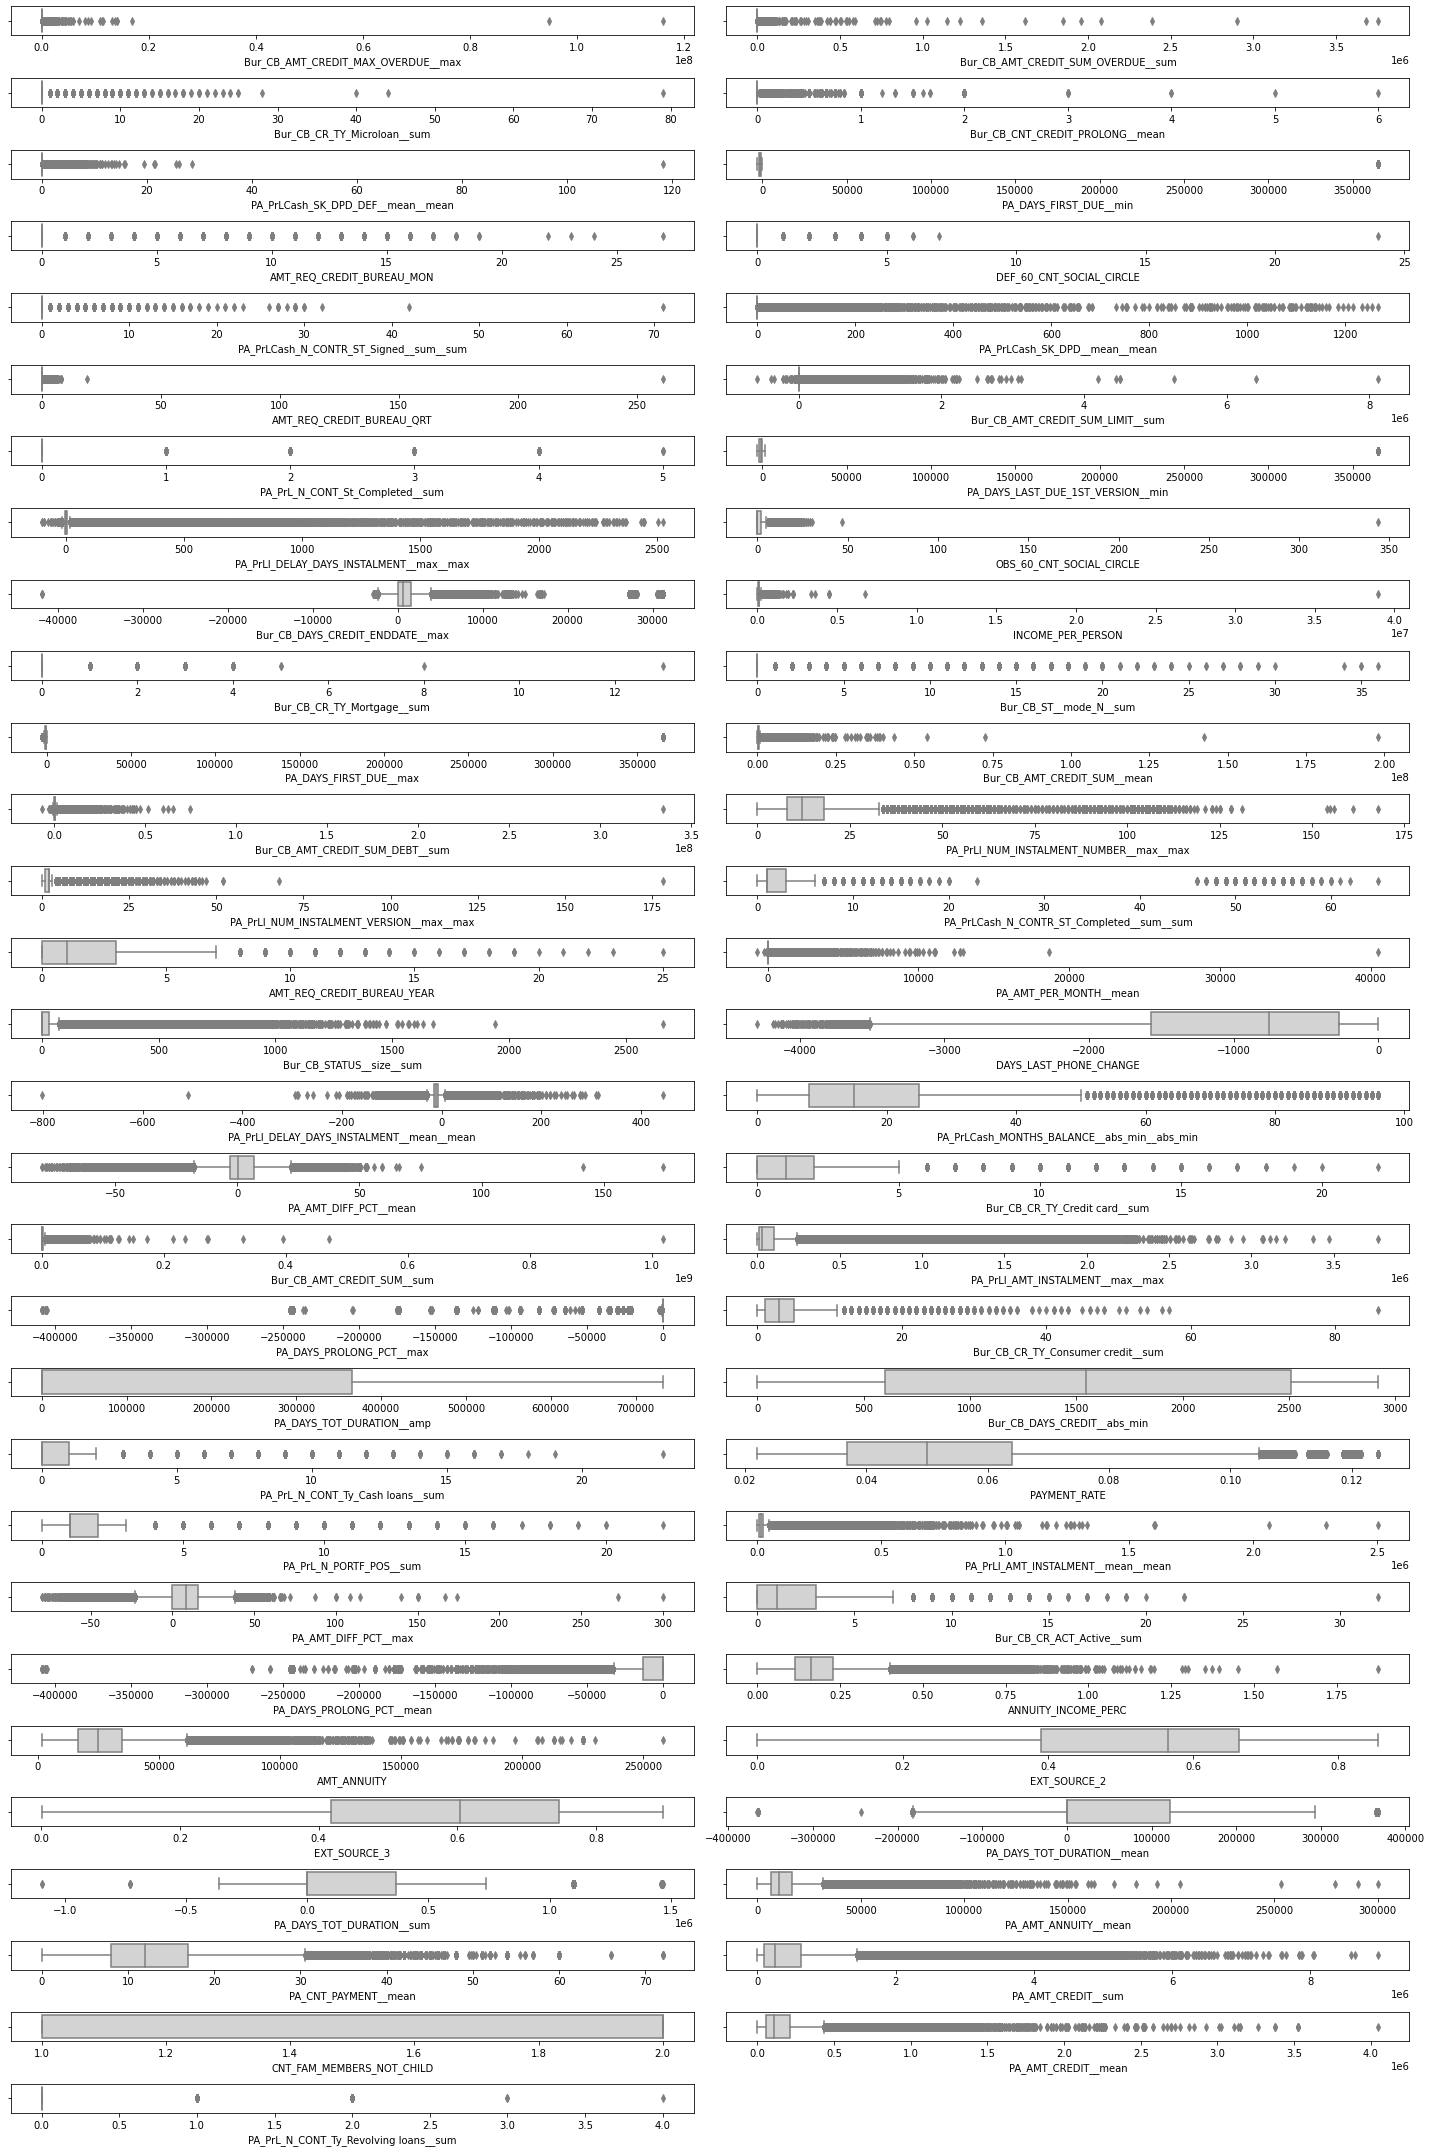

In [16]:
# Show outliers of each quantitative value

sel = quant_cols
width = 20
height = ((len(sel)+1)/2)*1

fig = plt.figure(figsize=(width, height))

for i, c in enumerate(sel,1):
    ax = fig.add_subplot((len(sel)+2)//2, 2, i)
    sns.boxplot(x=X_train[c], orient='h',
                color='lightgrey', ax=ax)
    
fig.tight_layout()

Some outliers may penalize the learning process.

We'll drop all the rows where a value is not within +/- 7 sigmas.

In [17]:
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler

thresh = 7
minmax = MinMaxScaler()

# Minmax scaling of each column

ind_outliers = []
for col in quant_cols:
    ser_ = X_tr[col]
    mask_outl = np.abs(st.zscore(ser_))>thresh
    ind_outliers.append(list(ser_.loc[mask_outl].index))

ind_outliers = list(set([i for sublist in ind_outliers for i in sublist]))

print(f"{len(ind_outliers)} rows will be dropped, i.e. \
{100*len(ind_outliers)/X_tr.shape[0]}% of the rows of 'X_tr'")

15089 rows will be dropped, i.e. 6.133540372670807% of the rows of 'X_tr'


In [18]:
# verification that outliers are not all of the target=1 type

print(f"{100*y_tr.loc[ind_outliers].sum()/len(ind_outliers)}% of outliers are target=1")
print(f"{100*y_tr.sum()/y_train.shape[0]}% of all the rows are target=1")

8.907150904632514% of outliers are target=1
6.458305556549196% of all the rows are target=1


### 2.2 Encoding categorical features and scaling

We perform the following treatment on the data:
- Standardscaler (quantitative values)
- Binary (ordinal encoding)
- Categorical - low card (one hot encoding)
- Categorical - high card (ordinal encoding)

In [19]:
X_train.shape, X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((307511, 97), (246008, 97), (61503, 97), (246008,), (61503,))

In [20]:
# custom transformer

import warnings
warnings.filterwarnings('ignore')

ct = CustTransformer(thresh_card=12,
                     strat_quant='stand',
                     strat_binary='ord',
                     strat_low_card='ohe',
                     strat_high_card='loo')

ct.fit(X_tr, y_tr)

X_tr_enc = ct.transform(X_tr) # y_tr is here for 'loo'
X_te_enc = ct.transform(X_te)

Here we add the 'AMT_CREDIT' column without standardization (in order to use this column to make a custom metric)

In [21]:
# X_tr_enc['AMT_CREDIT_not_enc'] = X_tr['AMT_CREDIT']
# X_te_enc['AMT_CREDIT_not_enc'] = X_te['AMT_CREDIT']

In [22]:
X_tr.shape, X_tr_enc.shape

((246008, 97), (246008, 124))

In [23]:
X_te.shape, X_te_enc.shape

((61503, 97), (61503, 124))

### 2.3 Resampling to reduce imbalance of the dataset

Several options are available when we  facing a imbalanced dataset:

- under-sampling when you have an a lot data (tens- or hundreds of thousands of instances or more)
- over-sampling when you don’t have a lot of data (tens of thousands of records or less)
- random and non-random (e.g. stratified) sampling schemes.
- different resampled ratios (e.g. you don’t have to target a 1:1 ratio in a binary classification problem, try other ratios)

We'll choose oversampling using SMOTE.

In [24]:
# # undersampling by hand...
# ind0 = y_tr[y_tr==0].sample(100000).index
# ind1 = y_tr[y_tr==1].index
# samp_ind = list(set(list(ind0)+list(ind1)))
# X_tr_samp = X_tr.loc[samp_ind]
# X_tr_enc_samp = X_tr_enc.loc[samp_ind]
# y_tr_samp = y_tr.loc[samp_ind]

In [25]:
from imblearn.over_sampling import SMOTE

In [26]:
# Oversampling using smote on X_tr_enc 

sm = SMOTE(sampling_strategy='auto', k_neighbors=5,
          n_jobs=-1, random_state=14) #'minority'
X_tr_enc_resamp, y_tr_resamp = sm.fit_resample(X_tr_enc, y_tr)

In [27]:
X_tr_enc_resamp.shape, y_tr_resamp.shape

((452296, 124), (452296,))

In [28]:
y_tr_resamp.value_counts(normalize=True)

1   0.50
0   0.50
Name: TARGET, dtype: float64

### 2.4 Data Visualization after preprocessing (2D projection)

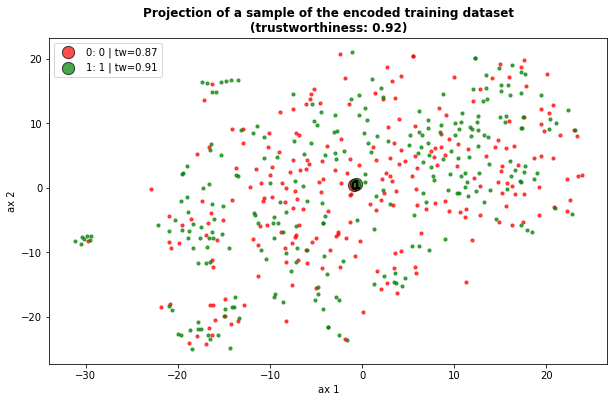

In [30]:
# Projection of a sample of the training set, colored with target value

ind_samp = X_tr_enc_resamp.sample(500).index

plot_projection(X=X_tr_enc_resamp.loc[ind_samp], #.drop(columns=['AMT_CREDIT_not_enc']),
                y=y_tr_resamp.loc[ind_samp], #.drop(columns=['AMT_CREDIT_not_enc']),
                model=None, ser_clust = y_tr_resamp.loc[ind_samp], proj='t-SNE', # dum_class # PCA, UMAP, t-SNE
                tw_n_neigh=5, title="Projection of a sample of the encoded training dataset",
                bboxtoanchor=None, figsize=(10, 6), size=10, palette=['r','g'], # 'tab10'
                legend_on=False, fig=None, ax=None, random_state=14)

## 3 Classification model

In [29]:
from sklearn.metrics import *
# classification_report, cohen_kappa_score, f1_score, fbeta_score, recall_score, precision_score, precision_recall_curve, auc, roc_curve, roc_auc_score

### 3.0 Metrics

In [122]:
from sklearn.metrics import *

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score, greater_is_better=True)
precision_scorer = make_scorer(precision_score, greater_is_better=True)
recall_scorer = make_scorer(recall_score, greater_is_better=True)
f1_scorer = make_scorer(fbeta_score, beta=1, greater_is_better=True)
f5_scorer = make_scorer(fbeta_score, beta=5, greater_is_better=True)
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
kappa_scorer = make_scorer(cohen_kappa_score, greater_is_better=True)
mcc_scorer = make_scorer(matthews_corrcoef, greater_is_better=True)

def gain_factor(y_true, y_pred):

    rate_gain = 0.1
    rate_loss = -1

    (tn, fp, fn, tp) = confusion_matrix(y_true, y_pred).ravel()
    actual_gain = (fn * rate_loss + tn * rate_gain)  # à maximiser
    min_gain = - (fn+tp) * 1
    max_gain =  (tn+fp) * 0.1
    
    return (actual_gain - min_gain) / (max_gain - min_gain)

gain_factor_scorer = make_scorer(gain_factor, greater_is_better=True) # needs_proba=True

In [205]:
# return all the scores


def model_scores(y_t, y_p, title, df=None):
    
    ser = pd.Series([
                        accuracy_score(y_t, y_p),
                        balanced_accuracy_score(y_t, y_p),
                        recall_score(y_t, y_p),
                        precision_score(y_t, y_p),
                        f1_score(y_t, y_p),
                        fbeta_score(y_t, y_p, beta=5), # favoring recall
                        roc_auc_score(y_t, y_p),
                        cohen_kappa_score(y_t, y_p),
                        matthews_corrcoef(y_t, y_p),
                        gain_factor(y_t, y_p),
                        ],
                        index=['accuracy',
                               'bal_accuracy',
                               'recall_score',
                               'precision_score',
                               'f1_score',
                               'f5_score',
                               'roc_auc_score',
                               'cohen_kapp',
                               'mcc_score',
                               'gain_factor'])
    
    df = pd.DataFrame() if df is None else df
    df[title] = ser
#     df = pd.concat([df, ser.to_frame()], axis=1)
    return df

SyntaxError: invalid syntax (<ipython-input-205-e10e61eedb09>, line 6)

### 3.1 Dummy Classifier (Baseline)

In [233]:
from sklearn.dummy import DummyClassifier

dum_class = DummyClassifier(strategy='most_frequent',
                            random_state=14)

dum_class.fit(X_tr_enc, y_tr) # .drop(columns=['AMT_CREDIT_not_enc'])

DummyClassifier(constant=None, random_state=14, strategy='most_frequent')

In [234]:
df_res = pd.DataFrame()

# Computes scores

y_pred_tr = dum_class.predict(X_tr_enc)
df_res = model_scores(y_tr, y_pred_tr, 'dummy_tr', df_res)

y_pred_te = dum_class.predict(X_te_enc)
df_res = model_scores(y_te, y_pred_te, 'dummy_te', df_res)

df_res

,dummy_tr,dummy_te
accuracy,0.92,0.92
bal_accuracy,0.50,0.50
recall_score,0.00,0.00
precision_score,0.00,0.00
f1_score,0.00,0.00
f5_score,0.00,0.00
roc_auc_score,0.50,0.50
cohen_kapp,0.00,0.00
mcc_score,0.00,0.00
gain_factor,0.53,0.53


In [236]:
# to get static sankey confusion graph
import plotly.graph_objects as go
from IPython.display import Image

img_bytes = plot_sankey_confusion_mat(cm, static=True, font_size=18,
                                      figsize=(2, 1.7), scale = 1)
Image(img_bytes)

ValueError: 
The orca executable is required to export figures as static images,
but it could not be found on the system path.

Searched for executable 'orca' on the following path:
    C:\ProgramData\Anaconda3
    C:\ProgramData\Anaconda3\Library\mingw-w64\bin
    C:\ProgramData\Anaconda3\Library\usr\bin
    C:\ProgramData\Anaconda3\Library\bin
    C:\ProgramData\Anaconda3\Scripts
    C:\Windows\system32
    C:\Windows
    C:\Windows\System32\Wbem
    C:\Windows\System32\WindowsPowerShell\v1.0\
    C:\Windows\System32\OpenSSH\
    C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common
    C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR
    C:\Program Files\Git\cmd
    C:\ProgramData\Anaconda3\Scripts
    C:\Users\Maryse\AppData\Local\Microsoft\WindowsApps
    C:\Program Files\JetBrains\PyCharm Community Edition 2020.3\bin
    
    C:\ProgramData\Anaconda3\lib\site-packages\llvmlite\binding

If you haven't installed orca yet, you can do so using conda as follows:

    $ conda install -c plotly plotly-orca

Alternatively, see other installation methods in the orca project README at
https://github.com/plotly/orca

After installation is complete, no further configuration should be needed.

If you have installed orca, then for some reason plotly.py was unable to
locate it. In this case, set the `plotly.io.orca.config.executable`
property to the full path of your orca executable. For example:

    >>> plotly.io.orca.config.executable = '/path/to/orca'

After updating this executable property, try the export operation again.
If it is successful then you may want to save this configuration so that it
will be applied automatically in future sessions. You can do this as follows:

    >>> plotly.io.orca.config.save()

If you're still having trouble, feel free to ask for help on the forums at
https://community.plot.ly/c/api/python


In [235]:
# computes confusion matrix
cm = pd.crosstab(y_te, y_pred_te)

# to get interactive sankey confusion graph
plot_sankey_confusion_mat(cm, static=False, figsize=(0.2, 0.7),
                          font_size=14, palette=['g', 'r'])

# # to get static sankey confusion graph
# import plotly.graph_objects as go
# from IPython.display import Image

# img_bytes = plot_sankey_confusion_mat(cm, static=True, font_size=18,
#                                       figsize=(2, 1.7), scale = 1)
# Image(img_bytes)

### 3.2 Simple Naive Bayes Classifier

In [222]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score


gnb_class = GaussianNB(priors=None,
                       var_smoothing=1e-9)

# # simple evaluation
gnb_class.fit(X_tr_enc_resamp, y_tr_resamp)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
# y_pred_proba = gnb_class.predict_proba (X_tr_enc_resamp)
# y_pred_log_proba = gnb_class.predict_log_proba(X_tr_enc_resamp)

In [225]:
# Computes scores

y_pred_tr = gnb_class.predict(X_tr_enc)
df_res = model_scores(y_tr, y_pred_tr, 'gnb_tr', df_res)

y_pred_te = gnb_class.predict(X_te_enc)
df_res = model_scores(y_te, y_pred_te, 'gnb_te', df_res)

df_res

,dummy_tr,dummy_te,gnb_tr,gnb_te
accuracy,0.92,0.92,0.18,0.18
bal_accuracy,0.50,0.50,0.53,0.52
recall_score,0.00,0.00,0.94,0.92
precision_score,0.00,0.00,0.09,0.08
f1_score,0.00,0.00,0.16,0.15
f5_score,0.00,0.00,0.68,0.66
roc_auc_score,0.50,0.50,0.53,0.52
cohen_kapp,0.00,0.00,0.01,0.01
mcc_score,0.00,0.00,0.05,0.03
gain_factor,0.53,0.53,0.50,0.49


In [231]:
# computes confusion matrix
cm = pd.crosstab(y_tr, y_pred)

# to get interactive sankey confusion graph
plot_sankey_confusion_mat(cm, static=False, figsize=(0.2, 0.7),
                          font_size=14, palette=['g', 'r'])

# # to get static sankey confusion graph
# import plotly.graph_objects as go
# from IPython.display import Image

# img_bytes = plot_sankey_confusion_mat(cm, static=True, font_size=18,
#                                       figsize=(2, 1.7), scale = 1)
# Image(img_bytes)

### 3.3 Model Selection (PyCaret)

Using the pre-processed data (see preprocessing §2) we'll use PyCaret to proceed to a fast spot checking of different classification models.

We'll use the encoded, not yet resampled dataset and let PyCaret take care of resampling.

In [38]:
# check pycaret version

import pycaret
print('PyCaret: %s' % pycaret.__version__)

PyCaret: 2.2.0


In [70]:
from pycaret.classification import *

In [63]:
# setup the dataset

data = pd.concat([X_tr_enc, y_tr], axis=1)

grid = setup(data=data,
             target='TARGET',
             fix_imbalance=True,
             data_split_stratify=True,
             remove_outliers=True,
             outliers_threshold=0.05,
             fold=7,
             use_gpu=False,
             profile=False,
             html=False,
             silent=True,
             verbose=False)

Setup Succesfully Completed! Loading Profile Now... Please Wait!


In [75]:
# check out the models available

models(raise_errors=False)

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsClassifier,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDClassifier,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessClassifier,False
mlp,MLP Classifier,pycaret.internal.tunable.TunableMLPClassifier,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


We choose 5 models (3 linear, 2 non-linear ensemble models) to try out.

In [80]:
# compare machine learning algorithms on preprocessed data (encoded and resampled)

best_models = compare_models(
                             include=['lda', 'svm', 'rf', 'lightgbm', 'mlp'],
                             fold=7,
                             cross_validation=True,
                             sort='recall',
                             n_select=5,
                             budget_time=None,
                             verbose=True
                            )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.85,0.91,0.80,0.32,0.45,0.38,0.44,8.57


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.85,0.91,0.80,0.32,0.45,0.38,0.44,8.57
svm,SVM - Linear Kernel,0.86,0.00,0.77,0.33,0.47,0.40,0.44,7.52


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.85,0.91,0.80,0.32,0.45,0.38,0.44,8.57
svm,SVM - Linear Kernel,0.86,0.00,0.77,0.33,0.47,0.40,0.44,7.52
rf,Random Forest Classifier,0.93,0.92,0.31,0.59,0.40,0.37,0.39,27.93


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.85,0.91,0.80,0.32,0.45,0.38,0.44,8.57
svm,SVM - Linear Kernel,0.86,0.00,0.77,0.33,0.47,0.40,0.44,7.52
lightgbm,Light Gradient Boosting Machine,0.94,0.94,0.44,0.64,0.52,0.49,0.50,9.40
rf,Random Forest Classifier,0.93,0.92,0.31,0.59,0.40,0.37,0.39,27.93


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.85,0.91,0.80,0.32,0.45,0.38,0.44,8.57
svm,SVM - Linear Kernel,0.86,0.00,0.77,0.33,0.47,0.40,0.44,7.52
mlp,MLP Classifier,0.90,0.89,0.53,0.42,0.46,0.41,0.42,140.73
lightgbm,Light Gradient Boosting Machine,0.94,0.94,0.44,0.64,0.52,0.49,0.50,9.40
rf,Random Forest Classifier,0.93,0.92,0.31,0.59,0.40,0.37,0.39,27.93


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.85,0.91,0.80,0.32,0.45,0.38,0.44,8.57
svm,SVM - Linear Kernel,0.86,0.00,0.77,0.33,0.47,0.40,0.44,7.52
mlp,MLP Classifier,0.90,0.89,0.53,0.42,0.46,0.41,0.42,140.73
lightgbm,Light Gradient Boosting Machine,0.94,0.94,0.44,0.64,0.52,0.49,0.50,9.40
rf,Random Forest Classifier,0.93,0.92,0.31,0.59,0.40,0.37,0.39,27.93


In [230]:
lda_model, svm_model, mlp_model = best_models

### 3.3 GridSearchCV Model Selection

In [139]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import LocalOutlierFactor

class LOFSampleFilter(BaseEstimator, TransformerMixin):

    def __init__(self, contamination=None, n_neighbors=None, **kwargs):
        self.contamination = contamination if contamination is not None else 0.05
        self.n_neighbors = n_neighbors if n_neighbors is not None else 5
        self.kwargs = kwargs

    def fit(self, X, y=None, *args, **kwargs):
        lcf = LocalOutlierFactor(n_neighbors=self.n_neighbors,
                                 contamination=self.contamination,
                                 **self.kwargs)
        samplefilter = pd.Series(lcf.fit_predict(X))
        samplefilter = samplefilter.replace({1: True, # inliners
                                          -1: False}) # outliers
        # computes the filtered dataframe
        self.X_mod = X.loc[samplefilter.values]
        if y is not None:
            self.y_mod = y.loc[samplefilter.values]
        return self

    def transform(self, X, y=None, copy=None):
        if y is not None:
            return self.X_mod, self.y_mod
        else:
            return self.X_mod

    def fit_transform(self, X, y=None, **fit_params):
        if y is None:
            return self.fit(X, **fit_params).transform(X)
        else:
            return self.fit(X, y, **fit_params).transform(X,y)


In [172]:
# imbalanced pipeline allowing to resample while cross-validating (resampling only in training folds)

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from lightgbm import LGBMClassifier

pipe = ImbPipeline([
                    ('preproc', CustTransformer(thresh_card=8)), # normalisation and encoding
#                     ('outl_filter', LOFSampleFilter()), # outlier cleaning  IsolForestSampleFilte
#                     ('resamp', SMOTE(random_state=14)), # resampling
                    ('clf', LGBMClassifier(random_state=14)) # classification
                   ])

# boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.1, n_estimators=100,
# subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0,
# min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0,
# colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, 

param_grid = {
              'preproc__strat_binary': ['ord'],
              'preproc__strat_low_card': ['ohe'],
              'preproc__strat_high_card': ['loo'],
              'preproc__strat_quant': ['stand'],
#               'resamp__k_neighbors': [5,10],
#               'outl_filter__contamination': [0.05, 0.1],
              'clf__is_unbalance': [True],
              'clf__n_estimators': [50, 100, 200,500],
#               'clf__num_leaves': [10, 20, 30, 400],
#               'clf__reg_alpha': [0, 0.1],
#               'clf__reg_lambda': [0,0.25,0.5],
#               'clf__learning_rate': [1e-2,5e-2,1e-1],
#               'clf__max_depth' :[-1,3],
                    
              }

             
gs = GridSearchCV(estimator = pipe,
                  param_grid = param_grid,
                  scoring = {'f5_scorer': f5_scorer,
                             'precision': precision_scorer,
                             'recall': recall_scorer,
                             'f1': f1_scorer,
                             'roc_auc': roc_auc_scorer,
                             'gain_factor': gain_factor_scorer,
                             'bal_accuracy': balanced_accuracy_scorer,
                             'kappa': kappa_scorer,
                             'mcc': mcc_scorer,
                             'gain': gain_factor_scorer},
                  # 'precision', 'recall', 'f1', 'roc_auc',  ['recall', 'roc_auc']
                  refit='gain',
                  cv=4,
                  verbose=1,
                  return_train_score=True)
                  

In [173]:
ind_samp = X_train.sample(1000).index

gs.fit(X_train.loc[ind_samp], y_train.loc[ind_samp])

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   13.6s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preproc',
                                        CustTransformer(strat_binary='ord',
                                                        strat_high_card='bin',
                                                        strat_low_card='ohe',
                                                        strat_quant='stand',
                                                        thresh_card=8)),
                                       ('clf',
                                        LGBMClassifier(boosting_type='gbdt',
                                                       class_weight=None,
                                                       colsample_bytree=1.0,
                                                       importance_type='split',
                                                       learning_rate=0.1,
                                                       m

In [174]:
gs.best_score_, gs.best_params_

(0.5419425756211262,
 {'clf__is_unbalance': True,
  'clf__n_estimators': 100,
  'preproc__strat_binary': 'ord',
  'preproc__strat_high_card': 'loo',
  'preproc__strat_low_card': 'ohe',
  'preproc__strat_quant': 'stand'})

In [179]:
best_model = gs.best_estimator_
y_tr_pred = best_model.predict(X_tr)
y_te_pred = best_model.predict(X_te)
y_train_pred = best_model.predict(X_train)

In [181]:
pd.crosstab(y_tr, y_tr_pred)

col_0,0,1
TARGET,,
0,218833,7315
1,18406,1454


In [180]:
model_scores(y_tr, y_tr_pred)

,0
bal_accuracy,0.52
recall_score,0.07
precision_score,0.17
f1_score,0.10
f1_5_score,0.07
roc_auc_score,0.52
cohen_kapp,0.05
mcc_score,0.06
gain_factor,0.55


In [136]:

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94    282686
           1       0.18      0.09      0.12     24825

    accuracy                           0.89    307511
   macro avg       0.55      0.53      0.53    307511
weighted avg       0.86      0.89      0.88    307511



#### Plot scores while tuning hyperparameters

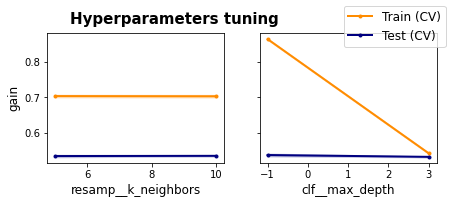

In [138]:
plot_hyperparam_tuning(gs, grid_params = param_grid,
                       params=['clf__max_depth',
                               'resamp__k_neighbors',
#                            'clf__num_leaves',
#                                'clf__n_estimators'
                              ],
                       score='gain',
                       pooled_std=False, agg_func=np.mean)

In [ ]:
plot_hyperparam_tuning(gs, grid_params = param_grid,
                       params=['resamp__k_neighbors',
                               'clf__n_estimators'],
                       score='roc_auc',
                       pooled_std=False, agg_func=np.mean)

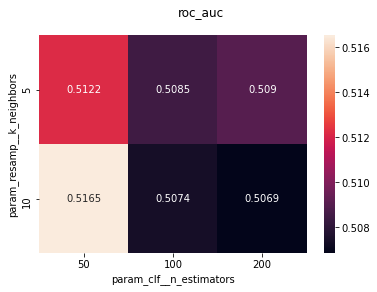

In [151]:
plot_2D_hyperparam_opt(gs, params=['resamp__k_neighbors',
                                   'clf__n_estimators'], score = 'roc_auc',
                       title=None, ax=None)

#### Learning curve

----- Learning curve not existing - computing...
-----...learning curve dumped


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

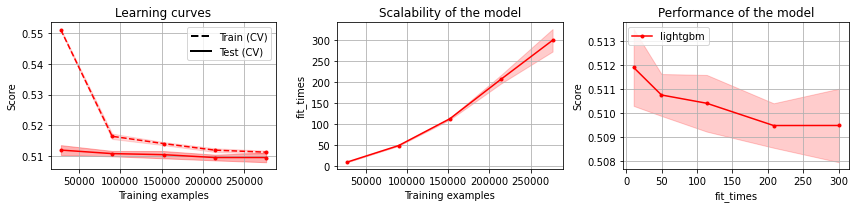

In [137]:
plot_learning_curve('lightgbm', pipe, X_train, y_train,
                    ylim=None, cv=10,
                    scoring=roc_auc_scorer,
                    score_name = "Score",
                    file_name='learning_curves',
                    dict_learn_curves=None,
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 5),
                    c='r',
                    axes=None,
                    title=None)

In [115]:
# from sklearn.model_selection import learning_curve

# train_sizes, train_scores, test_scores, fit_times, _ = \
#         learning_curve(pipe,
#                        X_train, y_train,
#                        cv=10, n_jobs=-1,
#                        train_sizes=np.linspace(.1, 1.0, 5),
#                        scoring = roc_auc_scorer,
#                        return_times=True) 

### 3.4 Bayesian Optimisation (OptunaSearchCV)

In [166]:
### OptunaSearchCV


import optuna
from optuna.distributions import IntUniformDistribution as IntUniDist
from optuna.distributions import UniformDistribution as UniDist
from optuna.distributions import LogUniformDistribution as LogUniDist
from optuna.distributions import CategoricalDistribution as CatDist
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from lightgbm import LGBMClassifier
# from sklearn.svm import SVC


pipe = ImbPipeline([
                    ('preproc', CustTransformer(thresh_card=8)), # normalisation and encoding
#                     ('outl_filter', IsolForestSampleFilter()), # outlier cleaning
                    ('resamp', SMOTE(random_state=14)), # resampling
                    ('clf', LGBMClassifier(random_state=14)) # classification
                   ])


param_distributions = {    
#                        'preproc__strat_binary': ['ord'],
#                         'preproc__strat_low_card': ['ohe'],
#                         'preproc__strat_high_card': ['loo'],
#                         'preproc__strat_quant': ['stand'],
#                   'resamp__k_neighbors': [5,10],
#  #             'outl_filter__n_estimators': [50,100],
              'clf__n_estimators': IntUniDist(50, 200),
              'clf__is_unbalance': CatDist([True, False]),
              'clf__n_estimators': IntUniDist(50, 500),
              'clf__num_leaves': IntUniDist(10, 400),
              'clf__reg_alpha': LogUniDist(1e-5, 1e0),
              'clf__reg_lambda':  LogUniDist(1e-5, 1e0),
              'clf__learning_rate': LogUniDist(1e-2, 1e-1),
              'clf__max_depth': IntUniDist(-1,3),
            }

optuna_search = optuna.integration.OptunaSearchCV(pipe,
                                                  param_distributions,
                                                  n_trials=1000,
                                                  timeout=600, # 10 minutes
                                                  verbose=2,
#                                                   scoring={'f5_scorer': f5_scorer,
#                                                            'precision': precision_scorer,
#                                                            'recall': recall_scorer,
#                                                            'f1': f1_scorer,
#                                                            'roc_auc': roc_auc_scorer,
#                                                            'bal_accuracy': balanced_accuracy_scorer,
#                                                            'kappa': kappa_scorer,
#                                                            'mcc': mcc_scorer,
#                                                            'gain': gain_factor_scorer},
                                                  refit=mcc_scorer,
                                                  cv=4,
                                                  return_train_score=True
                                                 )

optuna_search.fit(X_train, y_train)

[I 2021-01-03 14:37:17,435] A new study created in memory with name: no-name-5c8f544f-ffa0-4520-931e-52003ed1d367
[I 2021-01-03 14:37:17,436] Searching the best hyperparameters using 307511 samples...
[I 2021-01-03 14:52:29,682] Trial 0 finished with value: 0.9193232112948168 and parameters: {'clf__n_estimators': 198, 'clf__is_unbalance': True, 'clf__num_leaves': 239, 'clf__reg_alpha': 0.0025393917899727667, 'clf__reg_lambda': 0.6576927032235134, 'clf__learning_rate': 0.016299111510708016, 'clf__max_depth': 0}. Best is trial 0 with value: 0.9193232112948168.
[I 2021-01-03 14:52:29,683] Finished hyperparemeter search!
[I 2021-01-03 14:52:29,684] Refitting the estimator using 307511 samples...
[I 2021-01-03 14:58:20,458] Finished refitting! (elapsed time: 350.774 sec.)


OptunaSearchCV(cv=4, enable_pruning=False, error_score=nan,
               estimator=Pipeline(memory=None,
                                  steps=[('preproc',
                                          CustTransformer(strat_binary='ord',
                                                          strat_high_card='bin',
                                                          strat_low_card='ohe',
                                                          strat_quant='stand',
                                                          thresh_card=8)),
                                         ('resamp',
                                          SMOTE(k_neighbors=5, n_jobs=None,
                                                random_state=14,
                                                sampling_strategy='auto')),
                                         ('clf',
                                          LGBMClassifier(boosting_type='gbdt',
                                                  

In [168]:
print("Best trial:")
trial = optuna_search.study_.best_trial

print("  Value: ", trial.value)
print("  Params: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  0.9193232112948168
  Params: 
    clf__n_estimators: 198
    clf__is_unbalance: True
    clf__num_leaves: 239
    clf__reg_alpha: 0.0025393917899727667
    clf__reg_lambda: 0.6576927032235134
    clf__learning_rate: 0.016299111510708016
    clf__max_depth: 0


In [169]:
optuna_search.best_estimator_.predict(X_tr).sum()

136

In [171]:
# Validation score

y_pred = np.rint(optuna_search.best_estimator_.predict(X_te)) # num_iteration=optuna_search.best_iteration

model_scores(y_te, y_pred)

,0
bal_accuracy,0.50
recall_score,0.01
precision_score,0.88
f1_score,0.01
f1_5_score,0.01
roc_auc_score,0.50
cohen_kapp,0.01
mcc_score,0.07
gain_factor,0.54


In [ ]:
cm = pd.crosstab(test_y, y_pred, normalize=True)*100
cm

In [163]:
# speak("youpi c'est fini", 'fr')